In [1]:
import pandas as pd
import requests
from tqdm.auto import tqdm
from bs4 import BeautifulSoup as bs
import numpy as np
import math

# Scraping the main page
Here we will scrape the main page with all the links and names of museums in Russia using BeautifulSoup

In [3]:
source = requests.get('http://vrm.museum.ru/').text
soup = bs(source, 'lxml')

In [4]:
datapile = soup.find('div', class_='mlist')

In [5]:
columns = ['VRM_link', 'name', 'address', 'dates', 'budget_status', 'org_type', 'class', 'area', 'employees', 'visitors',
           'sponsors', 'storage']

In [6]:
df = pd.DataFrame(columns = columns)
df

for entry in datapile.find_all('a'):
    temp = pd.DataFrame(columns = columns, index = range(0,1)) 
    VRM_link = 'http://www.museum.ru' + entry['href']
    name = entry.text
    temp.iloc[0] = {'VRM_link': VRM_link, 'name': name}
    df = df.append(temp, ignore_index=True)
    
df.tail()

,VRM_link,name,address,dates,budget_status,org_type,class,area,employees,visitors,sponsors,storage
3024,http://www.museum.ru/M2326,Ярославский музей боевой славы,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3025,http://www.museum.ru/M1592,Ярославский художественный музей,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3026,http://www.museum.ru/M3010,Ярский историко-краеведческий музей,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3027,http://www.museum.ru/M724,Ярцевский историко-краеведческий музей,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3028,http://www.museum.ru/M601,Ясногорский художественно-краеведческий музей,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Scraping each museum's page
Here we will scrape each museum's page in the database using the dataframe (df) created on the previous stage. The database isn't well-organized in html. Therefore, we will have to resort to string analysis rather than using BeautifulSoup.

First, we'lll create a list of unique entries in the database because there's no documentation for it and we will have to explore it ourselves

In the following cells we find and count entries available in database

In [6]:
entries = pd.DataFrame(columns = ['entry', 'count']) #Creating an empty df for storage and counting

In [7]:
for j in tqdm(range (0, df.shape[0])):
    
    m_source = requests.get(df.iloc[j].VRM_link).text
    m_soup = bs(m_source, 'lxml')
    m_datapile = m_soup.find('center')
    
    for i in m_datapile.find_all('b'): 
        
        if ('http' not in i.text) & (':' in i.text):
            phrase = i.text.strip().replace('*','')
            
            if (entries.entry.isin([phrase]).sum() < 1):
                temp = pd.DataFrame(columns = ['entry', 'count'], index = range(0,1)) 
                temp.iloc[0].entry = phrase
                temp['count'][0] = 1
                entries = entries.append(temp, ignore_index=True)
            else:
                try:
                    ind = entries.index[entries.entry == phrase].tolist()[0]
                    entries['count'][ind] += 1
                except:
                    n=0 

In [307]:
entries.to_excel("saves/entries_save.xlsx")

In [308]:
entries = pd.read_excel("saves/entries_save.xlsx", index_col=0)

As we can see there are 99 unique entries in the base whch we define as a < b > tag on an html page. Not all of them are relevant, however they are instrumental for our future tasks

In [304]:
unique_entries = entries.entry.to_list()
unique_entries

['Адрес:',
 'Режим работы:',
 'Интернет:',
 'Адрес дирекции:',
 'Организационно-правовая форма:',
 'Виртуальные ресурсы:',
 'Бюджетный статус:',
 'Тип организации:',
 'Телефон:',
 'Проезд:',
 'Входная плата:',
 'Памятные даты и ежегодные мероприятия:',
 'Описание:',
 'Здание(я):',
 'Основатель:',
 'Основные экскурсии:',
 'Дополнительные услуги:',
 'Поблизости имеются:',
 'Местные достопримечательности:',
 'Основные должностные лица:',
 'Тел. дирекции:',
 'Даты открытия и основания:',
 'Классификация организации:',
 'Площади организации:',
 'Количество сотрудников:',
 'Среднее кол. посетителей в год:',
 'Вышестоящая организация:',
 'Организации партнеры:',
 'Единиц хранения:',
 'Наиболее ценные (уникальные) коллекции:',
 'Примечание:',
 'Официальное название организации:',
 'Образовательные услуги:',
 'В организации имеются коллективы:',
 'Крупные выставочные проекты:',
 'В структуре организации имеются:',
 'Выездные и обменные выставки:',
 'Издания, выпущенные организацией:',
 'Туристи

We need only a few entries for our research

In [16]:
select_entries = ['Адрес:', #0
                  'Даты открытия и основания:', #1
                  'Бюджетный статус:', #2
                  'Организационно-правовая форма:', #3
                  'Тип организации:', #4
                  'Классификация организации:', #5
                  'Площади организации:', #6
                  'Количество сотрудников:', #7
                  'Среднее кол. посетителей в год:', #8
                  'Спонсоры, меценаты и грантодатели:', #9
                  'Единиц хранения:'] #10

Here is a code for filling the dataframe with data from VRM. The website is quite inconsistent which makes the code a little bit complicated

In [57]:
for i in tqdm(range (0, df.shape[0])):
    
    m_source = requests.get(df.iloc[i].VRM_link).text
    m_soup = bs(m_source, 'lxml')
    m_datapile = m_soup.find('center')
    
    s = m_datapile.text
    s = s.replace('\xa0', '')
    s = s.replace('\r', '')
    s = s.replace('\t', '')
    s = s.replace('\n', ' ')
    
    stop_points = []
    for entry in unique_entries:
        try:
            point = s.index(entry)
            stop_points.append(point)
        except:
            n=0
    stop_points.sort(key=abs)
    
    for entry in select_entries:
        try:
            start = s.index(entry) + len(entry)
            for y in stop_points:
                if start < y:
                    end = y
                    break
            
            part_of_s = ''        
            for y in range(start, end):
                part_of_s += s[y]
                
            if entry == 'Адрес:':
                df.iloc[i].address = part_of_s.strip()
            if entry == 'Даты открытия и основания:':
                df.iloc[i].dates = part_of_s.strip()
            if entry == 'Бюджетный статус:':
                df.iloc[i].budget_status = part_of_s.strip()
            if entry == 'Организационно-правовая форма:':
                df.iloc[i].org_type = part_of_s.strip()
            if entry == 'Классификация организации:':
                df.iloc[i]['class'] = part_of_s.strip()
            if entry == 'Площади организации:':
                df.iloc[i].area = part_of_s.strip()
            if entry == 'Количество сотрудников:':
                df.iloc[i].employees = part_of_s.strip()
            if entry == 'Среднее кол. посетителей в год:':
                df.iloc[i].visitors = part_of_s.strip()
            if entry == 'Спонсоры, меценаты и грантодатели:':
                df.iloc[i].sponsors = part_of_s.strip()
            if entry == 'Единиц хранения:':
                df.iloc[i].storage = part_of_s.strip()
        except:
            n=0

In [309]:
df.to_excel('saves/df_save.xlsx')

In [310]:
df = pd.read_excel('saves/df_save.xlsx', index_col=0)

# Refining the dataset
We will need to standartize and refine the datasat for ease of future use and uniformity of values

#### Budget and Address

In [32]:
for i in range(0, df.shape[0]):
    
    try:
        df.iloc[i]['address'] = df.iloc[i]['address'].strip()
        df.iloc[i]['budget_status'] = df.iloc[i]['budget_status'].strip()
        
    except:
        n=0
        
    if df.iloc[i]['budget_status'] == '':
        df.iloc[i]['budget_status'] = float('nan')

In [312]:
df['budget_status'].unique()

array([nan, 'Субъект РФ', 'Муниципальный', 'Федеральный',
       'Общественная организация', 'Частная', 'Ведомственный', 'Личный'],
      dtype=object)

In [34]:
bs_unique = ['Субъект РФ', 'Муниципальный', 'Федеральный','Общественная организация', 'Частная', 'Ведомственный', 
             'Личный']

#### Class

In [311]:
#df['class'].unique()

array([nan,
       'естественнонаучная , историческая , краеведческая , художественная',
       'историческая , краеведческая',
       'историческая , краеведческая , театральная , художественная',
       'естественнонаучная , историческая , краеведческая',
       'естественнонаучная , историческая , краеведческая , музей-заповедник , персональная или мемориальная , художественная',
       'историческая , краеведческая , художественная', 'художественная',
       'историческая',
       'историческая , музыкальная , персональная или мемориальная',
       'архитектурно-ансамблевая , краеведческая , художественная',
       'краеведческая', 'краеведческая , художественная',
       'естественнонаучная , историческая , художественная',
       'историческая , науки, техники и отраслей н.х. , персональная или мемориальная , художественная',
       'естественнонаучная , художественная',
       'архитектурно-ансамблевая , историческая',
       'историческая , краеведческая , литературная , персон

In [36]:
classes = pd.DataFrame(columns= ['class', 'count'])

for i in tqdm(range(0, df.shape[0])):
    
    if isinstance(df.iloc[i]['class'], str) == True:
        
        df.iloc[i]['class'] = df.iloc[i]['class'].strip()
        s = df.iloc[i]['class']
        cls = ''
        
        for j in range(0, len(s)):
            
            if (s[j] != ' ') & (s[j] != ','):
                cls += s[j]
                
            elif (cls != '') & (classes['class'].isin([cls]).sum() < 1):
                temp = pd.DataFrame(columns= ['class', 'count'], index = range(0,1))
                temp.iloc[0] = {'class': cls, 'count': 1}
                classes = classes.append(temp, ignore_index=True)
                cls = ''
                
            elif (cls != '') & (classes['class'].isin([cls]).sum() >= 1):
                ind = classes.index[classes['class'] == cls].tolist()[0]
                classes['count'][ind] += 1
                cls = ''

In [37]:
#classes.sort_values('count', ascending = False)

In [38]:
uc_names = ['историческая', 'краеведческая', 'художественная', 'персональная или мемориальная', 'естественнонаучная',
                 'науки, техники и отраслей н.х.', 'литературная', 'архитектурно-ансамблевая', 'музей-заповедник',
                 'музыкальная', 'театральная']

In [274]:
uc_vars = ['c_historical', 'c_local_history', 'c_art', 'c_pers_memorial', 'c_nat_history', 'c_sci_tech',
          'c_literary', 'c_architectural', 'c_reserve', 'c_musical', 'c_theatrical']

In [40]:
unique_classes = pd.DataFrame(columns = ['name', 'variable'], index = range(0,len(uc_names)))
unique_classes.name = pd.Series(uc_names)
unique_classes.variable = pd.Series(uc_vars)

In [41]:
for uc in unique_classes.variable:
    df[uc] = 0

In [42]:
for i in tqdm(range(0, df.shape[0])):
    
    s = df.iloc[i]['class']
    
    if isinstance(s, str) == True:
        
        for j in range(0, unique_classes.shape[0]):
            
            name = unique_classes['name'][j]
            var = unique_classes['variable'][j]
            
            try:
                
                ind = s.index(name)
                end = ind + len(name)
                
                if s[ind:end] == name:
                    df[var][i] = 1
                    
            except:
                n=0

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


#### Organizational type

In [43]:
#df.org_type.unique()

In [44]:
for i in range(0, df.shape[0]):
    
    if isinstance(df.iloc[i]['org_type'], str) == True:
        
        df.iloc[i]['org_type'] = df.iloc[i]['org_type'].strip()

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
orgtype_names = ['некоммерческое учреждение', 'некоммерческая автономная', 'некоммерческое партнерство',
                 'коммерческая организация']
orgstat_vars = ['ot_ncinst', 'ot_ncaut', 'ot_ncpartner', 'ot_commercial']
orgstat = pd.DataFrame(columns = ['name', 'variable'], index = range(0,len(orgtype_names)))
orgstat.name = pd.Series(orgtype_names)
orgstat.variable = pd.Series(orgstat_vars)

In [46]:
for ot in orgstat.variable:
    df[ot] = 0

In [47]:
for i in tqdm(range(0, df.shape[0])):
    
    s = df.iloc[i]['org_type']
    
    if isinstance(s, str) == True:
        
        for j in range(0, orgstat.shape[0]):
            
            name = orgstat['name'][j]
            var = orgstat['variable'][j]
            
            try:
                
                ind = s.index(name)
                end = ind + len(name)
                
                if s[ind:end] == name:
                    df[var][i] = 1
                    
            except:
                n=0

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


#### Area

In [48]:
#df.area.unique()

In [49]:
areas = pd.DataFrame(columns= ['area_type', 'count'])
for i in tqdm(range(0, df.shape[0])):
    
    if isinstance(df.iloc[i]['area'], str) == True:
        
        df.iloc[i]['area'] = df.iloc[i]['area'].strip()
        dump = df.iloc[i]['area']
        area_type = ''
        
        for j in range(0, len(dump)):
            
            if (dump[j] != ' ') & (dump[j] != ',') & (dump[j].isnumeric() == False):
                
                area_type += dump[j]
                
            elif (area_type != '') & (areas['area_type'].isin([area_type]).sum() < 1):
                
                temp = pd.DataFrame(columns= ['area_type', 'count'], index = range(0,1))
                temp.iloc[0] = {'area_type': area_type, 'count': 1}
                areas = areas.append(temp, ignore_index=True)
                area_type = ''
                
            elif (area_type != '') & (areas['area_type'].isin([area_type]).sum() >= 1): 
                
                ind = areas.index[areas['area_type'] == area_type].tolist()[0]
                areas['count'][ind] += 1
                area_type = ''

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [50]:
#areas

In [51]:
areas_unique = ['экспозиционно-выставочная', 'временных выставок', 'фондохранилищ', 'парковая']
areas_vars = ['a_exhibition', 'a_temporary', 'a_storage','a_park']
areas = pd.DataFrame(columns = ['type', 'variable'], index = range(0, 4))
areas.type = pd.Series(areas_unique)
areas.variable = pd.Series(areas_vars)
#areas

In [52]:
#areas.iloc[0]['type']

In [53]:
df['a_exhibition'] = float('nan')
df['a_temporary'] = float('nan')
df['a_storage'] = float('nan')
df['a_park'] = float('nan')

In [54]:
for i in tqdm(range (0, df.shape[0])):
    
    s = df.iloc[i]['area']
    
    for j in range(0, areas.shape[0]):
        
        key = areas.iloc[j]['type']
        var = areas.iloc[j]['variable']
        
        try:
            
            spot = s.index(key)
            spot += len(key)
            flag = True
            result = ''
            
            for k in range(spot, len(s)):
                
                if (flag == True) & ((s[k].isnumeric() == True) or (s[k] == ',')):
                    
                    result += s[k]
                    
                elif s[k] == 'м':
                    
                    flag = False
                    
            result = result.replace(',', '.')
            df[var][i] = float(result)
            
        except:
            n = 0

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Employees

In [55]:
for i in tqdm(range(0, df.shape[0])):
    
    if df.iloc[i]['employees'] == '':
        
        df['employees'][i] = float('nan')
        
    if isinstance(df.iloc[i]['employees'], str) == True:
        
        df['employees'][i] = df.iloc[i]['employees'].strip()
        j = 0
        nemp = ''
        s = df.iloc[i]['employees']
        flag = False
        
        for j in range(0, len(s)):
            
            if flag == False:
                
                if s[j].isnumeric() == True:
                    
                    nemp += s[j]
                    
                elif s[j] == ',':
                    
                    flag = True
                    
        df['employees'][i] = int(nemp)

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Visitors

In [56]:
for i in tqdm(range(0, df.shape[0])):
    
    if isinstance(df.iloc[i]['visitors'], str) == True:
        
        df['visitors'][i] = df.iloc[i]['visitors'].strip()
        j = 0
        v = ''
        s = df.iloc[i]['visitors']
        flag = False
        
        for j in range(0, len(s)):
            
            if (s[j].isnumeric() == True) & (flag == False):
                
                v += s[j]
                
            elif s[j] == ',':
                
                flag = True
                
        df['visitors'][i] = int(v)

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


#### Storage

In [57]:
for i in tqdm(range(0, df.shape[0])):
    
    if isinstance(df.iloc[i]['storage'], str) == True:
        
        df['storage'][i] = df.iloc[i]['storage'].strip()
        j = 0
        storage = ''
        s = df.iloc[i]['storage']
        flag = False
        
        for j in range(0, len(s)):
            
            if (s[j].isnumeric() == True) & (flag == False):
                
                storage += s[j]
                
            elif s[j] == ',':
                
                flag = True
                
        df['storage'][i] = int(storage)

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


#### Date of Foundation

In [58]:
founded = 'основан:'
opened = 'открыт:'

In [59]:
df['year_founded'] = float('nan')

In [60]:
for i in tqdm(range(0, df.shape[0])):
    
    s = df.iloc[i].dates
    date = ''
    
    if isinstance(s, str) == True:
        
        try:
            
            ind = s.index(founded)
            
        except:
            
            ind = s.index(opened)
            
        for j in range(ind + 8, len(s)):
            
            if (s[j-4:j].isnumeric() == True) & (date == ''):
                
                flag = True
                date = s[j-4:j]
                df['year_founded'][i] = int(date)

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


#### Outliers elimination

In [61]:
columns_in_question = ['employees', 'visitors', 'storage', 'a_exhibition', 'a_temporary', 'a_storage', 'a_park']

In [62]:
lower_bound = 0.005
upper_bound = 0.995

In [63]:
for col in columns_in_question:
    
    l = df[col].quantile([lower_bound]).loc[lower_bound]
    u = df[col].quantile([upper_bound]).loc[upper_bound]
    df[col][df[col] < l] = float('nan')
    df[col][df[col] > u] = float('nan')

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Extracting Valuable Information

First, let's save our final dataset, so we won't have to run all of the code and wait

In [217]:
df.to_excel('df_final.xlsx')

In [221]:
df[df.budget_status == 'Федеральный'].a_exhibition.mean()

3350.4544067796605

In [223]:
df[df.budget_status == 'Частная'].shape[0]

158

Let's find differences between groups of museums divided by their budget status

In [278]:
status = df.budget_status.unique().tolist()
status = status[1:len(status)]

In [288]:
findings = pd.DataFrame(columns = ['budget_status', 'sum', 'avg_a_exhibition', 'avg_a_temporary',
                                   'avg_a_storage', 'avg_a_park', 'sum_c_historical', 'sum_c_local_history', 'sum_c_art',
                                   'sum_c_pers_memorial', 'sum_c_nat_history', 'sum_c_sci_tech', 'sum_c_literary',
                                  'sum_c_architectural', 'sum_c_reserve', 'sum_c_musical', 'sum_c_theatrical',
                                   'avg_employees', 'avg_visitors', 'avg_storage'],
                       index = range(0, len(status)))

In [289]:
findings.budget_status = pd.Series(status)

In [290]:
for i in range(0, findings.shape[0]):
    findings['sum'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['budget_status'].shape[0]
    
    findings['avg_a_exhibition'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['a_exhibition'].mean()
    findings['avg_a_temporary'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['a_temporary'].mean()
    findings['avg_a_storage'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['a_storage'].mean()
    findings['avg_a_park'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['a_park'].mean()
    
    findings['sum_c_historical'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_historical'].sum()
    findings['sum_c_local_history'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_local_history'].sum()
    findings['sum_c_art'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_art'].sum()
    findings['sum_c_pers_memorial'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_pers_memorial'].sum()
    findings['sum_c_nat_history'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_nat_history'].sum()
    findings['sum_c_sci_tech'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_sci_tech'].sum()
    findings['sum_c_literary'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_literary'].sum()
    findings['sum_c_architectural'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_architectural'].sum()
    findings['sum_c_reserve'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_reserve'].sum()
    findings['sum_c_musical'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_musical'].sum()
    findings['sum_c_theatrical'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['c_theatrical'].sum()
    
    findings['avg_employees'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['employees'].mean()
    findings['avg_visitors'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['visitors'].mean()
    findings['avg_storage'][i] = df[df.budget_status == findings.iloc[i]['budget_status']]['storage'].mean()

In [291]:
findings.to_excel('findings.xlsx')

In [287]:
df['visitors'][1854] = float('nan')

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Plotting the data

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [77]:
df.budget_status.unique()

array([nan, 'Субъект РФ', 'Муниципальный', 'Федеральный',
       'Общественная организация', 'Частная', 'Ведомственный', 'Личный'],
      dtype=object)

In [117]:
df_plots = df[(df.budget_status != 'Личный')]
df_plots = df_plots[df.budget_status != 'Общественная организация']
df_plots = df_plots[df.budget_status.isnull() != True]

C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Mvideo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


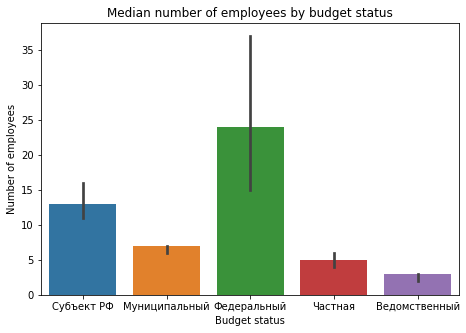

In [257]:
plt.figure(figsize=(7.5, 5))
plt.title('Median number of employees by budget status')
g = sns.barplot(x='budget_status',y='employees',data=df_plots, estimator=np.median)
g.set(xlabel = "Budget status", ylabel = "Number of employees")
plt.savefig('plots/median-number-of-employees-by-budget-status.png')
plt.show()

Private (Частная) museums tend to have less employees than almost all other types of museums by budget status

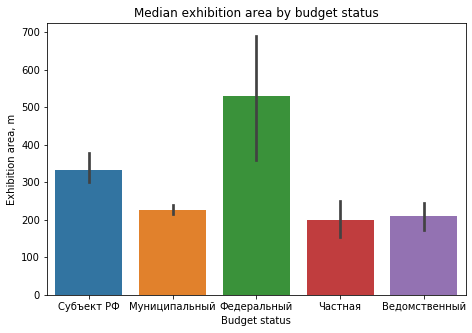

In [258]:
plt.figure(figsize=(7.5, 5))
plt.title('Median exhibition area by budget status')
g = sns.barplot(x='budget_status',y='a_exhibition',data=df_plots, estimator=np.median)
g.set(xlabel = "Budget status", ylabel = "Exhibition area, m")
plt.savefig('plots/median-exhibition-area-by-budget-status.png')
plt.show()

Private mueums have a smaller exhibition area than other types of museums

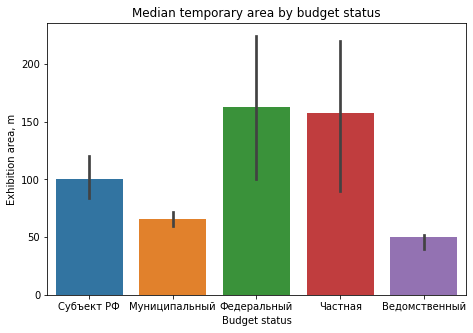

In [269]:
plt.figure(figsize=(7.5, 5))
plt.title('Median temporary area by budget status')
g = sns.barplot(x='budget_status',y='a_temporary',data=df_plots, estimator=np.median)
g.set(xlabel = "Budget status", ylabel = "Exhibition area, m")
plt.savefig('plots/median-temporary-area-by-budget-status.png')
plt.show()

However, lack of exhibition area in Private museums is compensated by bigger area for temporary projects

In [166]:
df_plots['meters_per_emp'] = (df_plots['a_exhibition'] + df_plots['a_temporary']) / df_plots['employees']

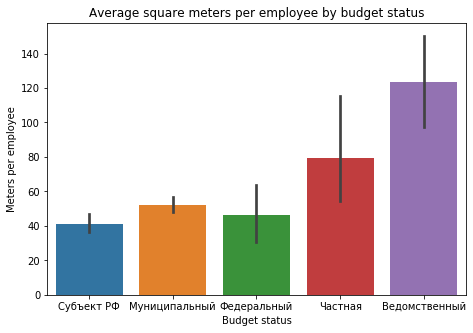

In [260]:
plt.figure(figsize=(7.5, 5))
plt.title('Average square meters per employee by budget status')
g = sns.barplot(x='budget_status',y='meters_per_emp',data=df_plots)
g.set(xlabel = "Budget status", ylabel = "Meters per employee")
plt.savefig('plots/average-square-meters-per-employee-by-budget-status.png')
plt.show()

Employees in private museums manage a bigger area than their colleagues in regional, municipal and federal establishments but a employees of ministerial museums have manage an even bigger area

In [236]:
df_plots['units_per_storage_area'] = df_plots['storage'] / df_plots['a_storage']

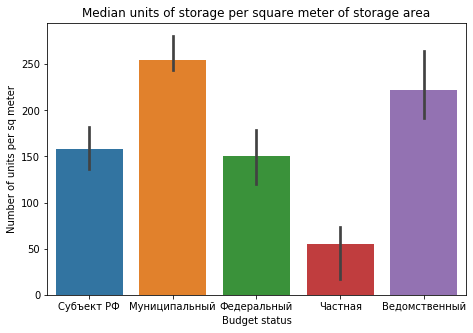

In [261]:
plt.figure(figsize=(7.5, 5))
plt.title('Median units of storage per square meter of storage area')
g = sns.barplot(x='budget_status',y='units_per_storage_area',data=df_plots, estimator=np.median)
g.set(xlabel = "Budget status", ylabel = "Number of units per sq meter")
plt.savefig('plots/median-units-of-storage-per-square-meter-of-storage-area.png')
plt.show()

Private museums store less items by square meter than other types of museum by their budget status. This can indicate inefficiency of storage area management or bigger size of storage units. The latter is more likely due to a big proportion of ceramics, coins and other small items in storage of other museums

In [265]:
budget_status = ['Субъект РФ', 'Муниципальный', 'Федеральный', 'Частная', 'Ведомственный']
df_pie = pd.DataFrame(columns = ['budget_status', 'percentage'], index = range(0,len(budget_status)))
df_pie.budget_status = pd.Series(budget_status)
for i in range(0,df_pie.shape[0]):
    df_pie['percentage'][i] = (df_plots.budget_status == df_pie['budget_status'][i]).sum() / df_plots.shape[0]

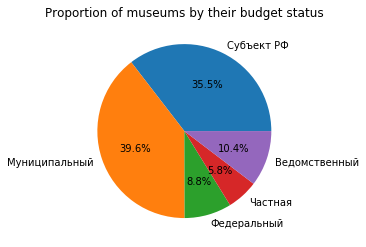

In [266]:
plt.title('Proportion of museums by their budget status')
plt.pie(df_pie.percentage.tolist(), labels = df_pie.budget_status.tolist(), autopct='%1.1f%%')
plt.savefig('plots/proportion-of-museums-by-their-budget-status.png')
plt.show()

Private museums represent 5,8% of the museums in Russia being a minority and a rarity

In [267]:
for i in range(0,df_pie.shape[0]):
    df_pie['percentage'][i] = (df_plots.a_exhibition[df_plots.budget_status == df_pie['budget_status'][i]].sum() +
                               df_plots.a_temporary[df_plots.budget_status == df_pie['budget_status'][i]].sum() / 
                               df_plots.shape[0])

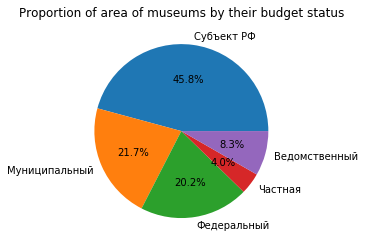

In [268]:
plt.title('Proportion of area of museums by their budget status')
plt.pie(df_pie.percentage.tolist(), labels = df_pie.budget_status.tolist(), autopct='%1.1f%%')
plt.savefig('plots/proportion-of-area-of-museums-by-their-budget-status.png')
plt.show()

Private museums have only 4% of the area of all museums in Russia

In [285]:
df_gbplt = pd.DataFrame(columns = ['budget_status', 'c_historical_perc', 'c_local_history_perc', 'c_art_perc',
                                  'c_pers_memorial_perc', 'c_nat_history_perc', 'c_sci_tech_perc', 'c_literary_perc',
                                  'c_architectural_perc', 'c_reserve_perc', 'c_musical_perc', 'c_theatrical_perc'],
                        index = range(0,len(budget_status)))
df_gbplt.budget_status = pd.Series(budget_status)

In [286]:
for i in range(0, df_gbplt.shape[0]):
    bs = df_plots[df_plots.budget_status == df_gbplt.iloc[i, 0]]
    bs_sum = bs.shape[0]
    for j in range(1, df_gbplt.shape[1]):
        c = df_gbplt.columns.tolist()[j].replace('_perc', '')
        c_bs_sum = (bs[c] == 1).sum()
        df_gbplt.iloc[i, j] = c_bs_sum / bs_sum    


In [287]:
df_gbplt = df_gbplt.set_index('budget_status')
del df_gbplt.index.name
df_gbplt = df_gbplt.T
df_gbplt = df_gbplt.reset_index()
#df_gbplt

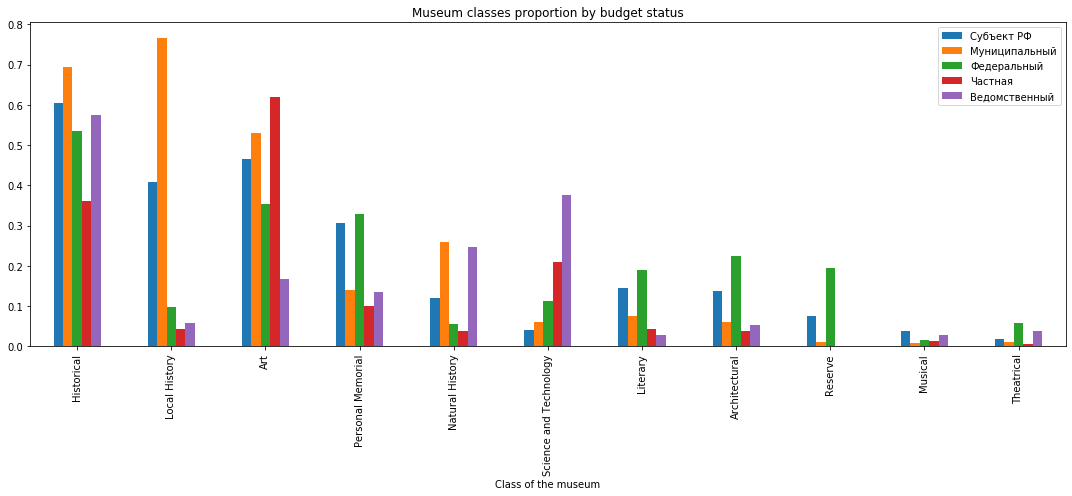

In [301]:
ax = df_gbplt.plot(x = 'index', y = budget_status, kind = "bar", title = 'Museum classes proportion by budget status',
             figsize=(15, 7))
ax.set_xticklabels(['Historical', 'Local History', 'Art', 'Personal Memorial', 'Natural History', 'Science and Technology',
                    'Literary', 'Architectural', 'Reserve', 'Musical', 'Theatrical'])
ax.set_xlabel("Class of the museum")
plt.tight_layout()
plt.savefig('plots/museum-classes-proportion-by-budget-status.png', dpi = 50)
plt.show()

Private museums are more likely to be an art museum than any other class. The top 3 classes for private museums are: art, historical, science and technology. All other classes probably don't provide enough interest for their investors.

# df variables guide

| Variable      | Description                                                  |Russian translation|
|---------------|:-----                                                        |-----  |
|VRM_link       |A link inside VRM database to access further information      | Ссылка внутри ВРМ для доступа к остальной информации |
|name           |Name of the organization                                      | Название организации |
|address        |Address of the organization                                   | Адрес организации |
|date           |Date of openning of the organization                          | Даты открытия и основания организации с лишними символами|
|budget_status  |Primary source of budget for the museum | Бюджетный статус, организация, формирующая большую часть бюджета |
|c_historical   |Historical class of the museum  | Классификация 'историческая'|
|c_local_history|Local history class of the museum | Классификация 'краеведческая'|
|c_art          |Art class of the museum  | Классификация 'художественная'|
|c_pers_memorial|Personal or memorial class of the museum  | Классификация 'персональная или мемориальная'|
|c_nat_history  |Natural history class of the museum  | Классификация 'естественнонаучная'|
|c_sci_tech     |Science and technology class of the museum  | Классификация 'науки, техники и отраслей н.х.'|
|c_literary     |Literary class of the museum  | Классификация 'литературная'|
|c_architectural|Architectural class of the museum  | Классификация 'архитектурно-ансамблевая'|
|c_reserve      |Reserve class of the museum  | Классификация 'музей-заповедник'|
|c_musical      |Musical class of the museum  | Классификация 'музыкальная'|
|c_theatrical   |Theatrical class of the museum  | Классификация 'театральная'|
|a_exibition    |Exhibition area of the museum, sq m  | Площадь 'экспозиционно-выставочная'|
|a_temporary    |Area for temporary projects of the museum, sq m   | Площадь 'временных выставок'|
|a_storage      |Storage area of the museum, sq m   | Площадь 'фондохранилищ'|
|a_park         |Park area of the museum, sq m   | Площадь 'парковая'|
|ot_ncinst      |Organizational type - noncommercial institution  | Организационный тип 'некоммерческое учреждение'|
|ot_ncaut       |Organizational type - noncommercial autonomous organization   | Организационный тип 'некоммерческая автономная'|
|ot_ncpartner   |Organizational type - noncommercial partner   | Организационный тип 'некоммерческое партнерство'|
|ot_commercial  |Organizational type - commercial organization   | Организационный тип 'коммерческая организация'|
|visitors       |Number of visitors per day  | Количество посетителей в год|
|employees      |Number of employees  | Количество сотрудников|
|storage        |Number of units of storage  | Единиц хранения|
|year_founded   |Year of foundation  | Год основания|